In [1]:
from numpy import array
from keras.models import Sequential
#from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import LSTM

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from subprocess import check_output
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import TimeDistributed
#from keras.layers.recurrent import LSTM
#from keras.models import Sequential
from sklearn.model_selection import train_test_split
import time #helper libraries
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import newaxis

Using TensorFlow backend.


# Function

In [2]:
from numpy import array
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps, out_seq):
    X, y = list(), []
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        eny = end_ix+out_seq
        if eny > len(sequence):
            break
        # gather input and output parts of the pattern
        #print(end_ix+out_seq,end_ix,len(sequence))
        #seq_x, seq_y, seq_y2 = sequence[i:end_ix], sequence[end_ix], sequence[eny] 
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:eny]
        X.append(seq_x)
        y.append(seq_y)
        #y.append(seq_y2)
    return array(X), array(y)

def split_sequence_test(sequence, n_steps1, n_steps2, n_loop):
    X, y = list(), []
    for i in range(n_loop):
        # find the end of this pattern
        end_ix = i*n_steps1
        # check if we are beyond the sequence
        eny = i*n_steps1 + n_steps2
        #print(i,end_ix,eny)
        if eny > len(sequence):
            break
        # gather input and output parts of the pattern
        #print(end_ix+out_seq,end_ix,len(sequence))
        #seq_x, seq_y, seq_y2 = sequence[i:end_ix], sequence[end_ix], sequence[eny] 
        seq_x = sequence[end_ix:eny]
        X.append(seq_x)
        #y.append(seq_y2)
    return array(X)

# Load Data

In [3]:
data = pd.read_csv('omlet_transfer_total_yok.csv',delimiter=',')
data.head(5)

,year,month,unit_type_id,province_id,district_id,transfer_total
0,2017,1,1,10,1003,12
1,2017,1,1,10,1005,4
2,2017,1,1,10,1010,10
3,2017,1,1,10,1011,7
4,2017,1,1,10,1020,5


In [4]:
data = data[data.unit_type_id == 3]
#data = data[data.district_id == 1030]

year_all = range(2014, 2020, 1)
month_all = range(1, 13, 1)
type_all = range(1, 7)

price_new_h = []
price_new_m = []
price_new_l = []
user_total_h = []
user_total_m = []
user_total_l = []

transfer_total = []
XGboost_tab = []

for year in year_all:
    
    for month in month_all:
        
        small_tab2 = data[(data.year == year) & (data.month == month)]
        
        record = {}
        record['year'] = year
        record['month'] = month
        #record['price_new_h'] = small_tab2['price_new'].max()
        #record['price_new_m'] = small_tab2['price_new'].mean()
        #record['price_new_l'] = small_tab2['price_new'].min()
            
        #record['district_id'] = small_tab2['district_id'].max()
            
        #record['user_total_h'] = small_tab2['user_total'].max()
        #record['user_total_m'] = small_tab2['user_total'].mean()
        #record['user_total_l'] = small_tab2['user_total'].min()
        a = small_tab2['transfer_total'].sum()
        if a == 17936:
            a = 5360.63
            
        record['transfer_total'] = a
        XGboost_tab.append(record)
        
XGboost_tab = pd.DataFrame(XGboost_tab) 
XGboost_tab = XGboost_tab[2:-2]
XGboost_tab = XGboost_tab.dropna()
XGboost_tab.head(5)

,year,month,transfer_total
2,2014,3,5415.0
3,2014,4,4121.0
4,2014,5,4584.0
5,2014,6,5020.0
6,2014,7,3546.0


# prepare Train Data

In [5]:
train = XGboost_tab[XGboost_tab.year < 2019]

del train['year']
del train['month']


train = train.values.astype('float32')
trainlist = train.tolist()
X, y = split_sequence(trainlist, 8, 2)
X.shape

(49, 8, 1)

In [6]:
n_timesteps, n_features = X.shape[1], X.shape[2]
X = X.reshape((X.shape[0], n_timesteps, n_features))
X.shape

(49, 8, 1)

In [7]:
y = y[:,:,0]
y = y.reshape(y.shape[0], y.shape[1])

# Stacked GRU

In [8]:
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import RMSprop

# Initializing the LSTM network 
model = Sequential() 
  
# Defining the cell type 
model.add(GRU(256, activation='relu', return_sequences=True,input_shape =(n_timesteps, n_features))) 
model.add(Dropout(0.1))
model.add(GRU(128, activation='relu', return_sequences=True)) 
model.add(Dropout(0.1))
model.add(GRU(56, activation='relu')) 
model.add(Dropout(0.1))

# Defining the densely connected Neural Network layer 
model.add(Dense(y.shape[1])) 
  
# Defining the activation function for the cell 
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])
for i in range(1000):
    model.fit(X, y, epochs=1, shuffle=False)
    model.reset_states()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Epoch 1/1
49/49 [==============================] - 2s 46ms/step - loss: 30248654.2041 - accuracy: 0.4694
Epoch 1/1
49/49 [==============================] - 0s 4ms/step - loss: 29476241.1429 - accuracy: 0.4082
Epoch 1/1
49/49 [==============================] - 0s 4ms/step - loss: 28923567.8367 - accuracy: 0.3878
Epoch 1/1
49/49 [==============================] - 0s 3ms/step - loss: 28312121.9592 - accuracy: 0.3673
Epoch 1/1
49/49 [==============================] - 0s 4ms/step - loss: 27567778.6939 - accuracy: 0.4082
Epoch 1/1
49/49 [==============================] - 0s 3ms/step - loss: 26923688.2041 - accuracy: 0.3878
Epoch 1/1
49/49 [==============================] - 0s 5ms/step - loss: 26098792.3673 - accuracy: 0.3265
Epoch 1/1
49/49 [==============================] - 0s 3ms/step - loss: 25447634.5714 - accuracy: 0.3878
Epoch 1/1
49/49 [==============================] - 0s 4ms/step - loss: 24637352.4898 

49/49 [==============================] - 0s 7ms/step - loss: 3496599.8367 - accuracy: 0.5510
Epoch 1/1
49/49 [==============================] - 0s 3ms/step - loss: 3872282.8367 - accuracy: 0.5510
Epoch 1/1
49/49 [==============================] - 0s 5ms/step - loss: 4152100.6429 - accuracy: 0.4898
Epoch 1/1
49/49 [==============================] - 0s 7ms/step - loss: 3936552.3776 - accuracy: 0.5714
Epoch 1/1
49/49 [==============================] - 0s 10ms/step - loss: 3707274.4388 - accuracy: 0.6122
Epoch 1/1
49/49 [==============================] - 0s 3ms/step - loss: 3847532.2857 - accuracy: 0.5510
Epoch 1/1
49/49 [==============================] - 0s 3ms/step - loss: 3945345.6020 - accuracy: 0.6531
Epoch 1/1
49/49 [==============================] - 1s 15ms/step - loss: 3841112.5612 - accuracy: 0.5510
Epoch 1/1
49/49 [==============================] - 0s 6ms/step - loss: 3595804.5765 - accuracy: 0.6531
Epoch 1/1
49/49 [==============================] - 0s 4ms/step - loss: 3731996.53

49/49 [==============================] - 0s 3ms/step - loss: 3388126.4643 - accuracy: 0.6122
Epoch 1/1
49/49 [==============================] - 0s 3ms/step - loss: 3587827.4643 - accuracy: 0.5510
Epoch 1/1
49/49 [==============================] - 0s 6ms/step - loss: 2947434.2755 - accuracy: 0.6327
Epoch 1/1
49/49 [==============================] - 0s 3ms/step - loss: 3371782.6888 - accuracy: 0.6735
Epoch 1/1
49/49 [==============================] - 0s 4ms/step - loss: 3487095.4490 - accuracy: 0.6327
Epoch 1/1
49/49 [==============================] - 0s 3ms/step - loss: 3698621.0714 - accuracy: 0.5918
Epoch 1/1
49/49 [==============================] - 0s 3ms/step - loss: 3521784.3929 - accuracy: 0.5306
Epoch 1/1
49/49 [==============================] - 0s 3ms/step - loss: 4028524.1888 - accuracy: 0.6939
Epoch 1/1
49/49 [==============================] - 0s 5ms/step - loss: 3583478.1480 - accuracy: 0.7143
Epoch 1/1
49/49 [==============================] - 0s 5ms/step - loss: 3619969.8878

49/49 [==============================] - 1s 11ms/step - loss: 2411331.9898 - accuracy: 0.7959
Epoch 1/1
49/49 [==============================] - 1s 24ms/step - loss: 2917209.2730 - accuracy: 0.7347
Epoch 1/1
49/49 [==============================] - 1s 24ms/step - loss: 2565461.2985 - accuracy: 0.7551
Epoch 1/1
49/49 [==============================] - 2s 41ms/step - loss: 2344414.4974 - accuracy: 0.7959
Epoch 1/1
49/49 [==============================] - 1s 18ms/step - loss: 2689658.1173 - accuracy: 0.8163
Epoch 1/1
49/49 [==============================] - 1s 19ms/step - loss: 2981175.7526 - accuracy: 0.7959
Epoch 1/1
49/49 [==============================] - 0s 7ms/step - loss: 2794462.5026 - accuracy: 0.7347
Epoch 1/1
49/49 [==============================] - 0s 3ms/step - loss: 2828358.9592 - accuracy: 0.7755
Epoch 1/1
49/49 [==============================] - 0s 5ms/step - loss: 2587667.5536 - accuracy: 0.7959
Epoch 1/1
49/49 [==============================] - 0s 3ms/step - loss: 261547

49/49 [==============================] - 0s 5ms/step - loss: 2044687.4732 - accuracy: 0.7959
Epoch 1/1
49/49 [==============================] - 0s 4ms/step - loss: 2065753.0536 - accuracy: 0.8980
Epoch 1/1
49/49 [==============================] - 0s 3ms/step - loss: 2305847.4719 - accuracy: 0.8163
Epoch 1/1
49/49 [==============================] - 0s 5ms/step - loss: 2459441.0995 - accuracy: 0.8367
Epoch 1/1
49/49 [==============================] - 0s 3ms/step - loss: 2536242.8393 - accuracy: 0.8571
Epoch 1/1
49/49 [==============================] - 0s 3ms/step - loss: 2542028.2806 - accuracy: 0.7959
Epoch 1/1
49/49 [==============================] - 0s 6ms/step - loss: 2526454.1964 - accuracy: 0.7551
Epoch 1/1
49/49 [==============================] - 0s 5ms/step - loss: 2425200.0791 - accuracy: 0.8367
Epoch 1/1
49/49 [==============================] - 0s 4ms/step - loss: 2661318.4974 - accuracy: 0.8776
Epoch 1/1
49/49 [==============================] - 0s 7ms/step - loss: 2374530.5026

49/49 [==============================] - 0s 4ms/step - loss: 2105348.2270 - accuracy: 0.8367
Epoch 1/1
49/49 [==============================] - 0s 3ms/step - loss: 2095395.1913 - accuracy: 0.8571
Epoch 1/1
49/49 [==============================] - 0s 8ms/step - loss: 1954168.8546 - accuracy: 0.7551
Epoch 1/1
49/49 [==============================] - 0s 3ms/step - loss: 2035372.3291 - accuracy: 0.8163
Epoch 1/1
49/49 [==============================] - 0s 4ms/step - loss: 2264339.9171 - accuracy: 0.8571
Epoch 1/1
49/49 [==============================] - 0s 3ms/step - loss: 1785496.7577 - accuracy: 0.8367
Epoch 1/1
49/49 [==============================] - 0s 4ms/step - loss: 1895017.4158 - accuracy: 0.8571
Epoch 1/1
49/49 [==============================] - 0s 3ms/step - loss: 1880883.8571 - accuracy: 0.8163
Epoch 1/1
49/49 [==============================] - 0s 10ms/step - loss: 2014524.2832 - accuracy: 0.8163
Epoch 1/1
49/49 [==============================] - 0s 4ms/step - loss: 1865237.385

49/49 [==============================] - 0s 5ms/step - loss: 1914316.1122 - accuracy: 0.8163
Epoch 1/1
49/49 [==============================] - 0s 4ms/step - loss: 1805686.2347 - accuracy: 0.8776
Epoch 1/1
49/49 [==============================] - 0s 4ms/step - loss: 1915941.6633 - accuracy: 0.7959
Epoch 1/1
49/49 [==============================] - 1s 10ms/step - loss: 1861315.9745 - accuracy: 0.8571
Epoch 1/1
49/49 [==============================] - 0s 5ms/step - loss: 2017391.4286 - accuracy: 0.8776
Epoch 1/1
49/49 [==============================] - 0s 4ms/step - loss: 1944763.4847 - accuracy: 0.8776
Epoch 1/1
49/49 [==============================] - 0s 3ms/step - loss: 1947056.1429 - accuracy: 0.8367
Epoch 1/1
49/49 [==============================] - 0s 3ms/step - loss: 1808089.3418 - accuracy: 0.7959
Epoch 1/1
49/49 [==============================] - 0s 4ms/step - loss: 1940698.0893 - accuracy: 0.7755
Epoch 1/1
49/49 [==============================] - 1s 13ms/step - loss: 1833680.09

# Test Data

In [9]:
test = XGboost_tab[XGboost_tab.year >= 2018]
test = test[4:]
del test['year']
del test['month']

test = test.values.astype('float32')
testlist = test.tolist()
test_sequence = split_sequence_test(testlist, 2, 8, 6)

In [10]:
x_Test = test_sequence.reshape((test_sequence.shape[0], test_sequence.shape[1], test_sequence.shape[2]))
yhat = model.predict(x_Test,verbose=0)
yhat = yhat.reshape(12,)
pred = pd.DataFrame(yhat, columns=['Prediction'])
answer = pd.DataFrame(test, columns=['transfer_total'])
answer = answer[6:].reset_index()

mape = ((abs(answer['transfer_total'] - pred ['Prediction']))/answer['transfer_total'])*100

answer['Prediction'] = yhat
answer['month'] = [1,2,3,4,5,6,7,8,9,10,11,12]
answer['Error'] = mape
answer.head(10)

,index,transfer_total,Prediction,month,Error
0,6,6756.0,5714.321777,1,15.418566
1,7,8586.0,6214.568848,2,27.619743
2,8,4294.0,7321.756348,3,70.511330
3,9,4320.0,5501.038086,4,27.338844
4,10,7560.0,3564.249268,5,52.853848
5,11,3080.0,6095.859863,6,97.917526
6,12,3857.0,3793.189209,7,1.654415
7,13,5083.0,4689.139648,8,7.748581
8,14,5820.0,6575.937500,9,12.988617
9,15,6824.0,4944.731445,10,27.539104


# Results

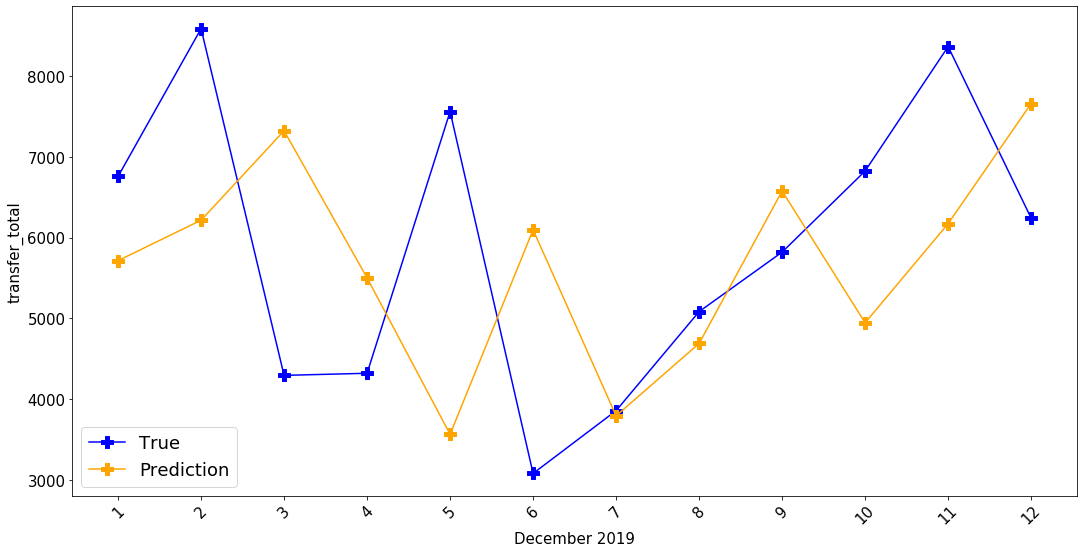

In [11]:
plt.figure(figsize = (18,9))
plt.plot(range(answer.shape[0]), answer['transfer_total'], marker= 'P',markersize=12 , color='b',label='True')
plt.plot(range(answer.shape[0]),answer['Prediction'], marker= 'P', markersize=12, color='orange',label='Prediction')
plt.xticks(range(answer.shape[0]),answer['month'], rotation=45, size = 15)
plt.yticks(size = 15)
plt.xlabel('December 2019', size = 15)
plt.ylabel('transfer_total', size = 15)

plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.legend(fontsize=18)
plt.show()